<a href="https://colab.research.google.com/github/Jourialgh/FetalVision-AI-Enabled-Real-Time-Fetal-Biometry-and-Abnormality-Detection-in-2D-Ultrasound/blob/main/FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [ ]:
!kaggle datasets download -d theunkovvn/fetal-head-circumference

Dataset URL: https://www.kaggle.com/datasets/theunkovvn/fetal-head-circumference
License(s): MIT
 88% 149M/169M [00:01<00:00, 113MB/s]
100% 169M/169M [00:01<00:00, 125MB/s]


In [ ]:
import zipfile

In [ ]:
with zipfile.ZipFile("fetal-head-circumference.zip", "r") as zip_ref:
    zip_ref.extractall()

In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import glob

In [ ]:
img_directory=""
mask_directory=""
size=256
num_img=999

In [ ]:
image_names=glob.glob("/content/data/train/images/*.png")

image_names.sort()

print(len(image_names))
image_names_subset=image_names[0:num_img]
images=[cv2.imread(img,0) for img in image_names_subset]
images=[cv2.resize(img,(256,256)) for img in images]
image_dataset=np.array(images)
print(image_dataset.shape)

image_dataset=np.expand_dims(image_dataset, axis=3)

699
(699, 256, 256)


In [ ]:
mask_names=glob.glob("/content/data/train/annotations/*.png")

mask_names.sort()
mask_names_subset=mask_names[0:num_img]
masks=[cv2.imread(mask,0) for mask in mask_names_subset]
masks=[cv2.resize(mask,(256,256)) for mask in masks]
mask_dataset=np.array(masks)
mask_dataset=np.expand_dims(mask_dataset, axis=3)

In [ ]:
image_names=glob.glob("/content/data/test/images/*.png")
image_names.sort()

print(len(image_names))
image_names_subset=image_names[0:num_img]
images=[cv2.imread(img,0) for img in image_names_subset]
images=[cv2.resize(img,(256,256)) for img in images]
image_dataset=np.array(images)
print(image_dataset.shape)

image_dataset=np.expand_dims(image_dataset, axis=3)

101
(101, 256, 256)


In [ ]:
mask_names=glob.glob("/content/data/test/annotations/*.png")

mask_names.sort()
mask_names_subset=mask_names[0:num_img]
masks=[cv2.imread(mask,0) for mask in mask_names_subset]
masks=[cv2.resize(mask,(256,256)) for mask in masks]
mask_dataset=np.array(masks)
mask_dataset=np.expand_dims(mask_dataset, axis=3)

In [ ]:
image_names=glob.glob("/content/data/val/images/*.png")

image_names.sort()

print(len(image_names))
image_names_subset=image_names[0:num_img]
images=[cv2.imread(img,0) for img in image_names_subset]
images=[cv2.resize(img,(256,256)) for img in images]
image_dataset=np.array(images)
print(image_dataset.shape)

image_dataset=np.expand_dims(image_dataset, axis=3)

199
(199, 256, 256)


In [ ]:
mask_names=glob.glob("/content/data/val/annotations/*.png")

mask_names.sort()
mask_names_subset=mask_names[0:num_img]
masks=[cv2.imread(mask,0) for mask in mask_names_subset]
masks=[cv2.resize(mask,(256,256)) for mask in masks]
mask_dataset=np.array(masks)
mask_dataset=np.expand_dims(mask_dataset, axis=3)

In [ ]:
mask_dataset.shape

(199, 256, 256, 1)

In [ ]:
image_dataset=image_dataset/256
mask_dataset=mask_dataset/256

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(image_dataset,mask_dataset, test_size=.2, random_state=42)

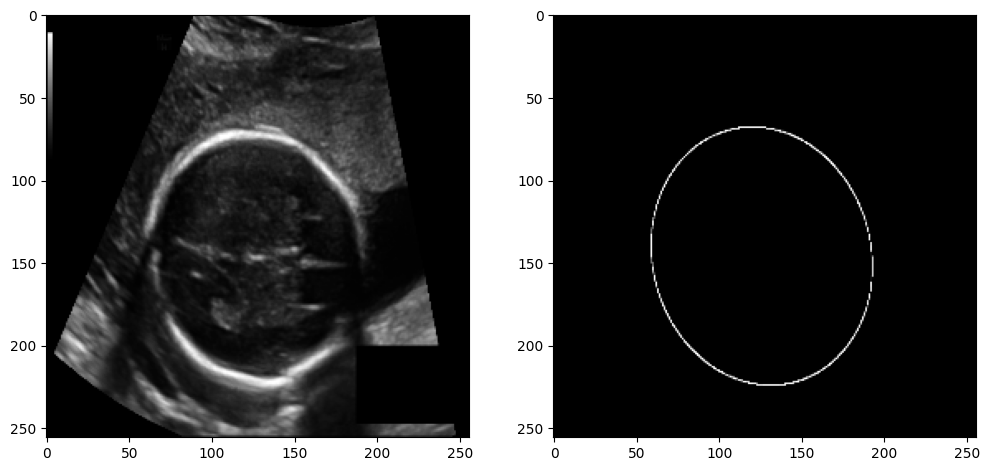

In [ ]:
import random
image_number=random.randint(0,len(X_train))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0],cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap="gray")
plt.show()

In [ ]:
X_train[image_number,:,:,0].shape

(256, 256)

In [ ]:
!pip install keras

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose

In [ ]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from keras.optimizers import Adam

In [ ]:
def build_fcn(input_shape, n_classes):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bridge
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Conv2D(512, 2, activation='relu', padding='same')(up6)
    up7 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Conv2D(256, 2, activation='relu', padding='same')(up7)
    up8 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Conv2D(128, 2, activation='relu', padding='same')(up8)
    up9 = UpSampling2D(size=(2, 2))(conv8)
    conv9 = Conv2D(64, 2, activation='relu', padding='same')(up9)

    outputs = Conv2D(n_classes, 1, activation='sigmoid')(conv9)

    model = Model(inputs, outputs, name='FCN')
    return model

# Already defined X_train, y_train, X_test, and y_test
input_shape = X_train[0].shape
model = build_fcn(input_shape, n_classes=1)
model.summary()

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 256)       295168  

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    batch_size=3,
                    verbose=1,
                    epochs=3,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/3
53/53 [==============================] - 17s 109ms/step - loss: 0.1768 - accuracy: 0.9826 - val_loss: 0.0563 - val_accuracy: 0.9884
Epoch 2/3
53/53 [==============================] - 5s 88ms/step - loss: 0.0467 - accuracy: 0.9890 - val_loss: 0.0451 - val_accuracy: 0.9884
Epoch 3/3
53/53 [==============================] - 5s 88ms/step - loss: 0.0413 - accuracy: 0.9890 - val_loss: 0.0413 - val_accuracy: 0.9884


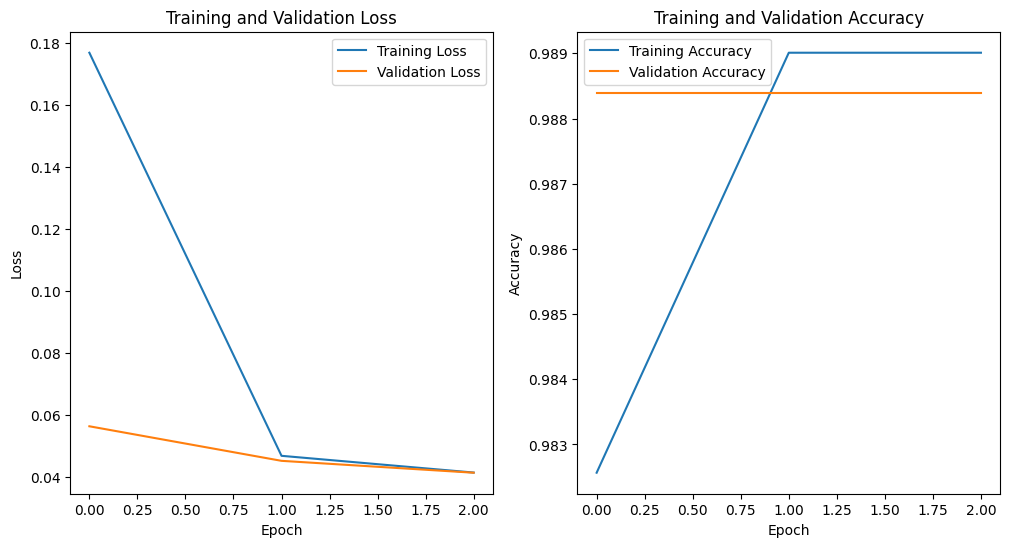

2/2 [==============================] - 9s 3s/step - loss: 0.0413 - accuracy: 0.9884
Test Loss: 0.04126802086830139
Test Accuracy: 0.988385796546936
2/2 [==============================] - 0s 222ms/step


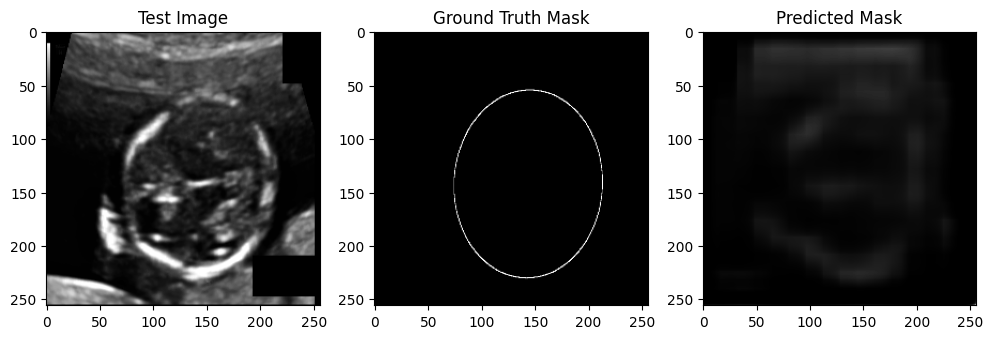

In [ ]:
import matplotlib.pyplot as plt

# Visualize training history
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Visualize a random sample from the test set along with its prediction and ground truth
import random

random_index = random.randint(0, len(X_test) - 1)
test_image = X_test[random_index]
ground_truth_mask = y_test[random_index]
predicted_mask = y_pred[random_index]

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(test_image.squeeze(), cmap='gray')
plt.title('Test Image')

plt.subplot(132)
plt.imshow(ground_truth_mask.squeeze(), cmap='gray')
plt.title('Ground Truth Mask')

plt.subplot(133)
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.title('Predicted Mask')

plt.show()
